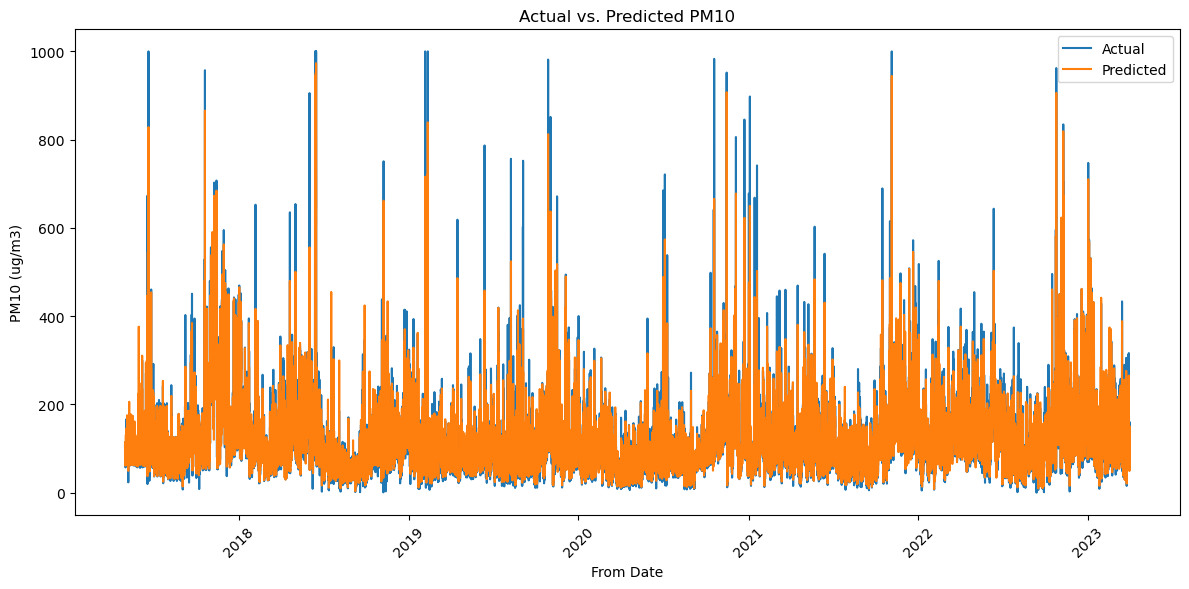

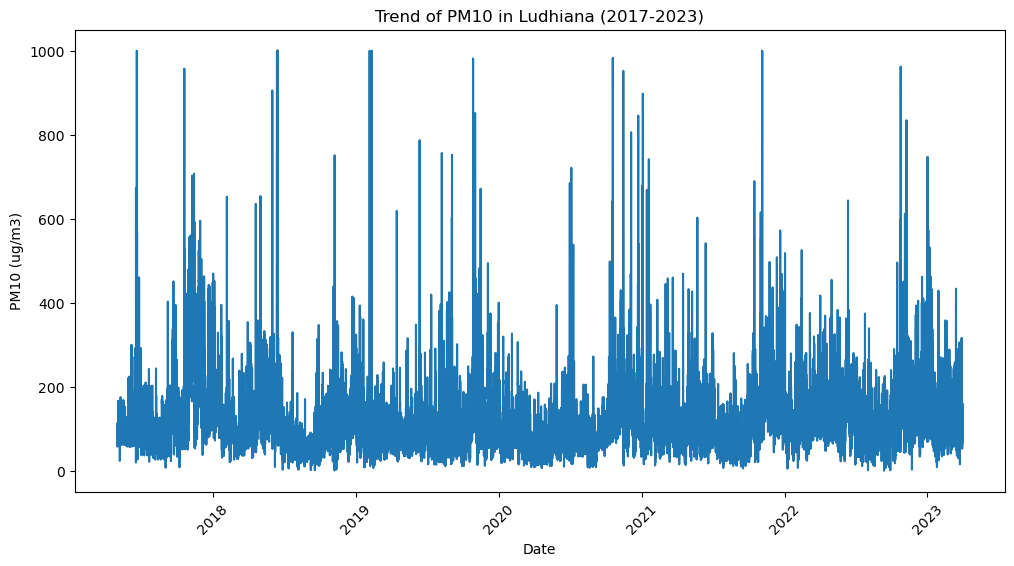

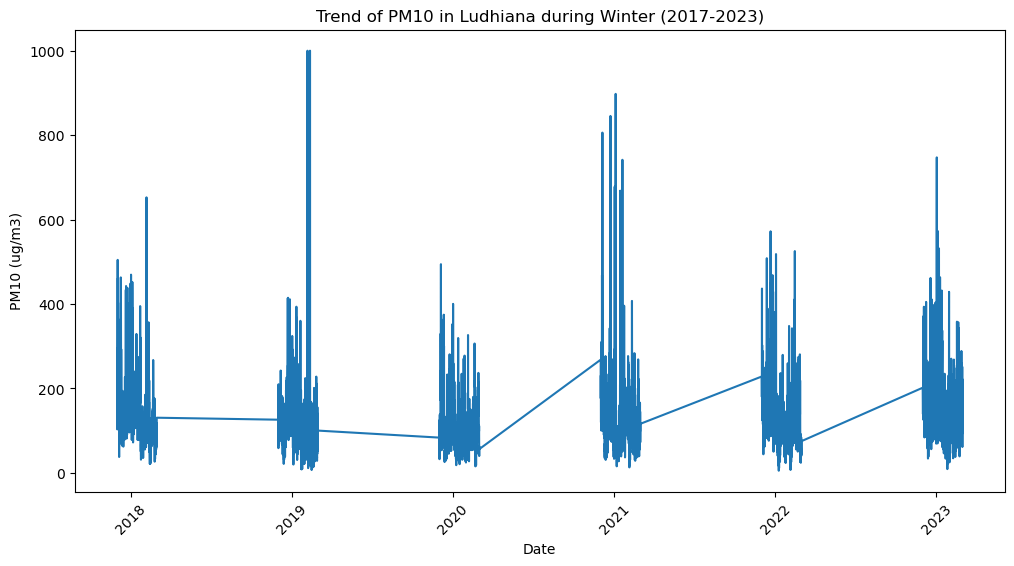

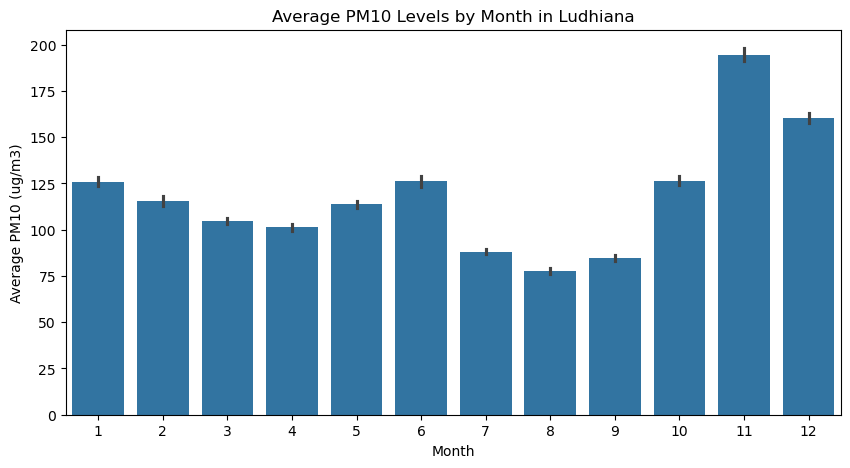


Feature Importance:
            Feature  Importance
0     PM2.5 (ug/m3)    0.702661
2       NO2 (ug/m3)    0.031190
6        CO (mg/m3)    0.030842
10  Temp (degree C)    0.022209
4       NH3 (ug/m3)    0.022053
8   Benzene (ug/m3)    0.020016
3         NOx (ppb)    0.019541
9   Toluene (ug/m3)    0.018929
7     Ozone (ug/m3)    0.017443
5       SO2 (ug/m3)    0.015849
1        NO (ug/m3)    0.015470
11           RH (%)    0.015322
12         WS (m/s)    0.014378
13         WD (deg)    0.013569
14       SR (W/mt2)    0.012385
15             Hour    0.012209
17            Month    0.008238
16        DayOfWeek    0.007694


In [9]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

#1. Load and Preprocess Data (Only needs to be done once and then you can load the saved preprocessed data)
try:
    df = pd.read_csv("PB003.csv")  # Load your dataset
except FileNotFoundError:
    print("Error: PB003.csv not found. Please check the file path.")
    exit()


df['From Date'] = pd.to_datetime(df['From Date'], format="%d-%m-%Y %H:%M")
df['To Date'] = pd.to_datetime(df['To Date'], format="%d-%m-%Y %H:%M")

df['Hour'] = df['From Date'].dt.hour
df['DayOfWeek'] = df['From Date'].dt.dayofweek
df['Month'] = df['From Date'].dt.month

df_knn = df.drop(['From Date', 'To Date'], axis=1)  # Drop date columns for imputation


# Use this block to load preprocessed data if already saved
try:
    df_imputed = pd.read_csv("PB003_preprocessed.csv")
    target_column = 'PM10 (ug/m3)'
    features = [col for col in df_imputed.columns if col not in [target_column, 'From Date', 'To Date']]
    X = df_imputed[features]
    model = joblib.load("trained_model_PM10.joblib")

except FileNotFoundError: # If not, preprocess and save it
    imputer = KNNImputer(n_neighbors=5)
    df_imputed_knn = pd.DataFrame(imputer.fit_transform(df_knn), columns=df_knn.columns)


    df_imputed = df_imputed_knn.copy()
    df_imputed['From Date'] = df['From Date']
    df_imputed['To Date'] = df['To Date']


    # Save preprocessed data (so you don't need to impute every time)
    df_imputed.to_csv("PB003_preprocessed.csv", index=False)

    target_column = 'PM10 (ug/m3)'  # Define your target variable
    features = [col for col in df_imputed.columns if col not in [target_column, 'From Date', 'To Date']]

    X = df_imputed[features] # Features for model training
    y = df_imputed[target_column]


    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    joblib.dump(model, "trained_model_PM10.joblib")  # Save trained model


# 2. Load the Saved Model
model = joblib.load("trained_model_PM10.joblib") # Load the model for prediction


# 3. Make Predictions (if needed)
df_imputed['Predictions'] = model.predict(X)  #(Only X, the features!)



# 4. Visualizations
# ... (Your visualization code from previous responses)
#      Actual Vs predicted
plt.figure(figsize=(12, 6))
sns.lineplot(x='From Date', y=target_column, data=df_imputed, label='Actual') # df_imputed has datetimes
sns.lineplot(x='From Date', y='Predictions', data=df_imputed, label='Predicted')  
plt.title('Actual vs. Predicted PM10')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 1. Trend of AQI 2017-2023
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
sns.lineplot(x='From Date', y='PM10 (ug/m3)', data=df_imputed)
plt.title('Trend of PM10 in Ludhiana (2017-2023)')
plt.xlabel('Date')
plt.ylabel('PM10 (ug/m3)')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()



# 2. Trend of AQI in Winter Seasons
winter_months = [12, 1, 2]  # December, January, February
df_winter = df_imputed[df_imputed['From Date'].dt.month.isin(winter_months)]

plt.figure(figsize=(12, 6))
sns.lineplot(x='From Date', y='PM10 (ug/m3)', data=df_winter)
plt.title('Trend of PM10 in Ludhiana during Winter (2017-2023)')
plt.xlabel('Date')
plt.ylabel('PM10 (ug/m3)')
plt.xticks(rotation=45)
plt.show()







# 4. Most Polluted Months of the Year
plt.figure(figsize=(10, 5))
sns.barplot(x=df_imputed['From Date'].dt.month, y='PM10 (ug/m3)', data=df_imputed, estimator='mean')  # Use estimator='mean' for average PM2.5
plt.title('Average PM10 Levels by Month in Ludhiana')
plt.xlabel('Month')
plt.ylabel('Average PM10 (ug/m3)')
plt.show()

# ... (Add other visualizations here) ...

#Feature Importance

feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
print("\nFeature Importance:")
print(feature_importance_df.sort_values(by='Importance', ascending=False))